# Predicting Telco Customer Churn with a Business-Centric Approach

## Project Overview

### Objective
This project aims to build a classification model that accurately identifies customers at risk of churning. The final model selection will be driven by a custom business metric that reflects the financial impact of retention efforts.

### Business Context
Customer churn is a critical challenge in the telecommunications industry. Acquiring new customers costs significantly more than retaining existing ones. This analysis will:
- Identify key drivers of customer churn
- Build predictive models to identify at-risk customers
- Optimize models based on business costs and benefits
- Provide actionable insights for customer retention strategies

### Methodology
1. **Advanced Exploratory Data Analysis (EDA)**: Deep dive into patterns and relationships
2. **Feature Selection**: Select meaningful features based on business insights
3. **Unsupervised Learning**: Customer segmentation using K-Means clustering
4. **Class Balancing**: Compare cluster-based undersampling vs SMOTE oversampling
5. **Model Training**: Train multiple algorithms with cross-validation (5 Classification Models)
6. **Business Optimization**: Threshold tuning based on custom business metrics
7. **Model Selection**: Choose the best model based on business value (Custom Evaluation Score)

---

## 1. Setup and Configuration

Setting up the environment with all necessary libraries and global configurations for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from statsmodels.stats.outliers_influence import variance_inflation_factor

import joblib
from IPython.display import display, HTML

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

print("Setup complete! All libraries imported successfully.")
print(f"Random state set to: {RANDOM_STATE}")
print(f"Python version: {pd.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")

Setup complete! All libraries imported successfully.
Random state set to: 42
Python version: 2.2.2
Pandas version: 2.2.2
Numpy version: 2.0.2
Seaborn version: 0.13.2


## 2. Data Loading and Initial Inspection

In [2]:
df = pd.read_csv('telco_customer_churn.csv')

print("Dataset Overview")
print("=" * 50)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print("\nColumn Information:")
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

Dataset Overview
Shape: 7043 rows × 21 columns
Memory usage: 1.13 MB

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Advanced Data Health Check

Comprehensive assessment of data quality including missing values, data types, and cardinality.

In [3]:
def data_health_check(df):
    """Performing comprehensive data quality assessment"""

    health_report = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes.values,
        'Missing Count': df.isnull().sum().values,
        'Missing %': (df.isnull().sum().values / len(df) * 100).round(2),
        'Unique Values': df.nunique().values,
        'Cardinality': (df.nunique().values / len(df) * 100).round(2)
    })

    health_report['Sample Values'] = [df[col].dropna().unique()[:3].tolist() for col in df.columns]
    return health_report

health_df = data_health_check(df)
print("Data Health Report")
print("=" * 80)
display(health_df)

duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")

Data Health Report


,Column,Data Type,Missing Count,Missing %,Unique Values,Cardinality,Sample Values
0,customerID,object,0,0.0,7043,100.00,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK]"
1,gender,object,0,0.0,2,0.03,"[Female, Male]"
2,SeniorCitizen,int64,0,0.0,2,0.03,"[0, 1]"
3,Partner,object,0,0.0,2,0.03,"[Yes, No]"
4,Dependents,object,0,0.0,2,0.03,"[No, Yes]"
5,tenure,int64,0,0.0,73,1.04,"[1, 34, 2]"
6,PhoneService,object,0,0.0,2,0.03,"[No, Yes]"
7,MultipleLines,object,0,0.0,3,0.04,"[No phone service, No, Yes]"
8,InternetService,object,0,0.0,3,0.04,"[DSL, Fiber optic, No]"
9,OnlineSecurity,object,0,0.0,3,0.04,"[No, Yes, No internet service]"



Duplicate rows: 0 (0.00%)


In [4]:
print("TotalCharges column...")
print(f"Current data type: {df['TotalCharges'].dtype}")

non_numeric_mask = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()
non_numeric_values = df.loc[non_numeric_mask, 'TotalCharges'].unique()
print(f"\nNon-numeric values found: {non_numeric_values}")
print(f"Count of non-numeric values: {non_numeric_mask.sum()}")

if non_numeric_mask.sum() > 0:
    print("\nAnalysis of records with non-numeric TotalCharges:")
    problematic_records = df[non_numeric_mask][['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']]
    display(problematic_records.head(10))
    tenure_zero = (df[non_numeric_mask]['tenure'] == 0).all()
    print(f"\nAll records with missing TotalCharges have tenure=0: {tenure_zero}")
    if tenure_zero:
        print("\nJustification: Imputing TotalCharges with 0 for tenure=0 customers (new customers)")

TotalCharges column...
Current data type: object

Non-numeric values found: [' ']
Count of non-numeric values: 11

Analysis of records with non-numeric TotalCharges:


,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,
753,3115-CZMZD,0,20.25,
936,5709-LVOEQ,0,80.85,
1082,4367-NUYAO,0,25.75,
1340,1371-DWPAZ,0,56.05,
3331,7644-OMVMY,0,19.85,
3826,3213-VVOLG,0,25.35,
4380,2520-SGTTA,0,20.00,
5218,2923-ARZLG,0,19.70,
6670,4075-WKNIU,0,73.35,



All records with missing TotalCharges have tenure=0: True

Justification: Imputing TotalCharges with 0 for tenure=0 customers (new customers)


In [5]:
print("Cleaning and preprocessing data...")

df['TotalCharges'] = df['TotalCharges'].replace(' ', '0')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

print(f"TotalCharges converted to: {df['TotalCharges'].dtype}")
print(f"Missing values after conversion: {df['TotalCharges'].isnull().sum()}")

print("\nSummary Statistics for Numeric Features:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[numeric_cols].describe())

Cleaning and preprocessing data...
TotalCharges converted to: float64
Missing values after conversion: 0

Summary Statistics for Numeric Features:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


## 4. Target Variable Analysis and Class Imbalance

Understanding the distribution of our target variable is crucial for setting baseline expectations.

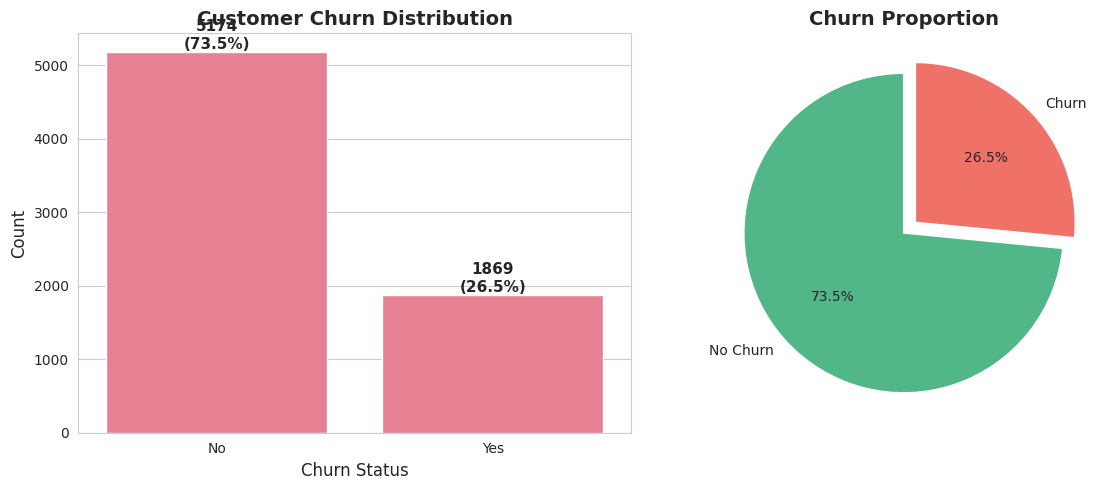

Class Imbalance Analysis
No Churn: 5174 (73.46%)
Churn: 1869 (26.54%)

Imbalance Ratio: 2.77:1
Baseline Accuracy (always predict 'No'): 73.46%

Training Implication: Significant class imbalance detected!
   This will be carefully handled through balanced sampling.


In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
churn_counts = df['Churn'].value_counts()
churn_percentages = df['Churn'].value_counts(normalize=True) * 100

ax1 = sns.countplot(data=df, x='Churn', ax=axes[0])
axes[0].set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

for i, (count, percentage) in enumerate(zip(churn_counts, churn_percentages)):
    ax1.text(i, count + 50, f'{count}\n({percentage:.1f}%)',
             ha='center', fontsize=11, fontweight='bold')

colors = ['#52b788', '#f07167']
axes[1].pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0, 0.1))
axes[1].set_title('Churn Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

imbalance_ratio = churn_counts[0] / churn_counts[1]
baseline_accuracy = churn_percentages[0]

print("Class Imbalance Analysis")
print("=" * 50)
print(f"No Churn: {churn_counts[0]} ({churn_percentages[0]:.2f}%)")
print(f"Churn: {churn_counts[1]} ({churn_percentages[1]:.2f}%)")
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Baseline Accuracy (always predict 'No'): {baseline_accuracy:.2f}%")
print("\nTraining Implication: Significant class imbalance detected!")
print("   This will be carefully handled through balanced sampling.")

## 5. Advanced Correlation Analysis

### 5.1 Spearman Correlation for Numeric Features

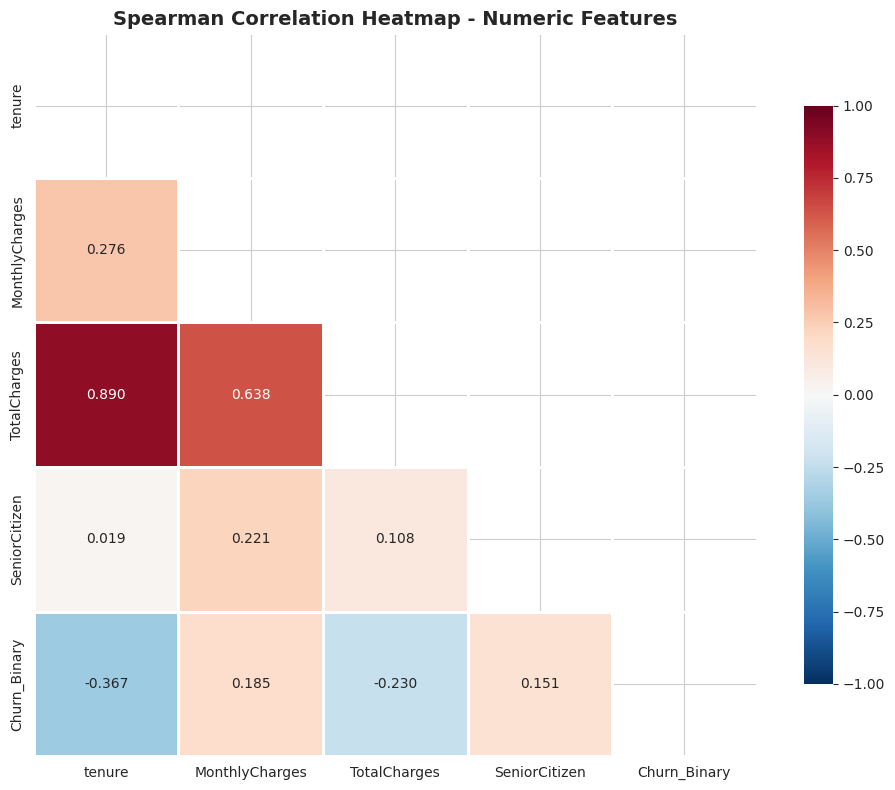

Numeric Features Correlation with Churn:
tenure               : 0.367
TotalCharges         : 0.230
MonthlyCharges       : 0.185
SeniorCitizen        : 0.151


In [7]:
df['Churn_Binary'] = df['Churn'].map({'No': 0, 'Yes': 1})

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Churn_Binary']
numeric_df = df[numeric_features]

spearman_corr = numeric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
sns.heatmap(spearman_corr, mask=mask, annot=True, fmt='.3f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Spearman Correlation Heatmap - Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

target_correlations = spearman_corr['Churn_Binary'].drop('Churn_Binary').abs().sort_values(ascending=False)
print("Numeric Features Correlation with Churn:")
print("=" * 40)
for feature, corr in target_correlations.items():
    print(f"{feature:20} : {corr:.3f}")

### 5.2 Cramér's V for Categorical Features

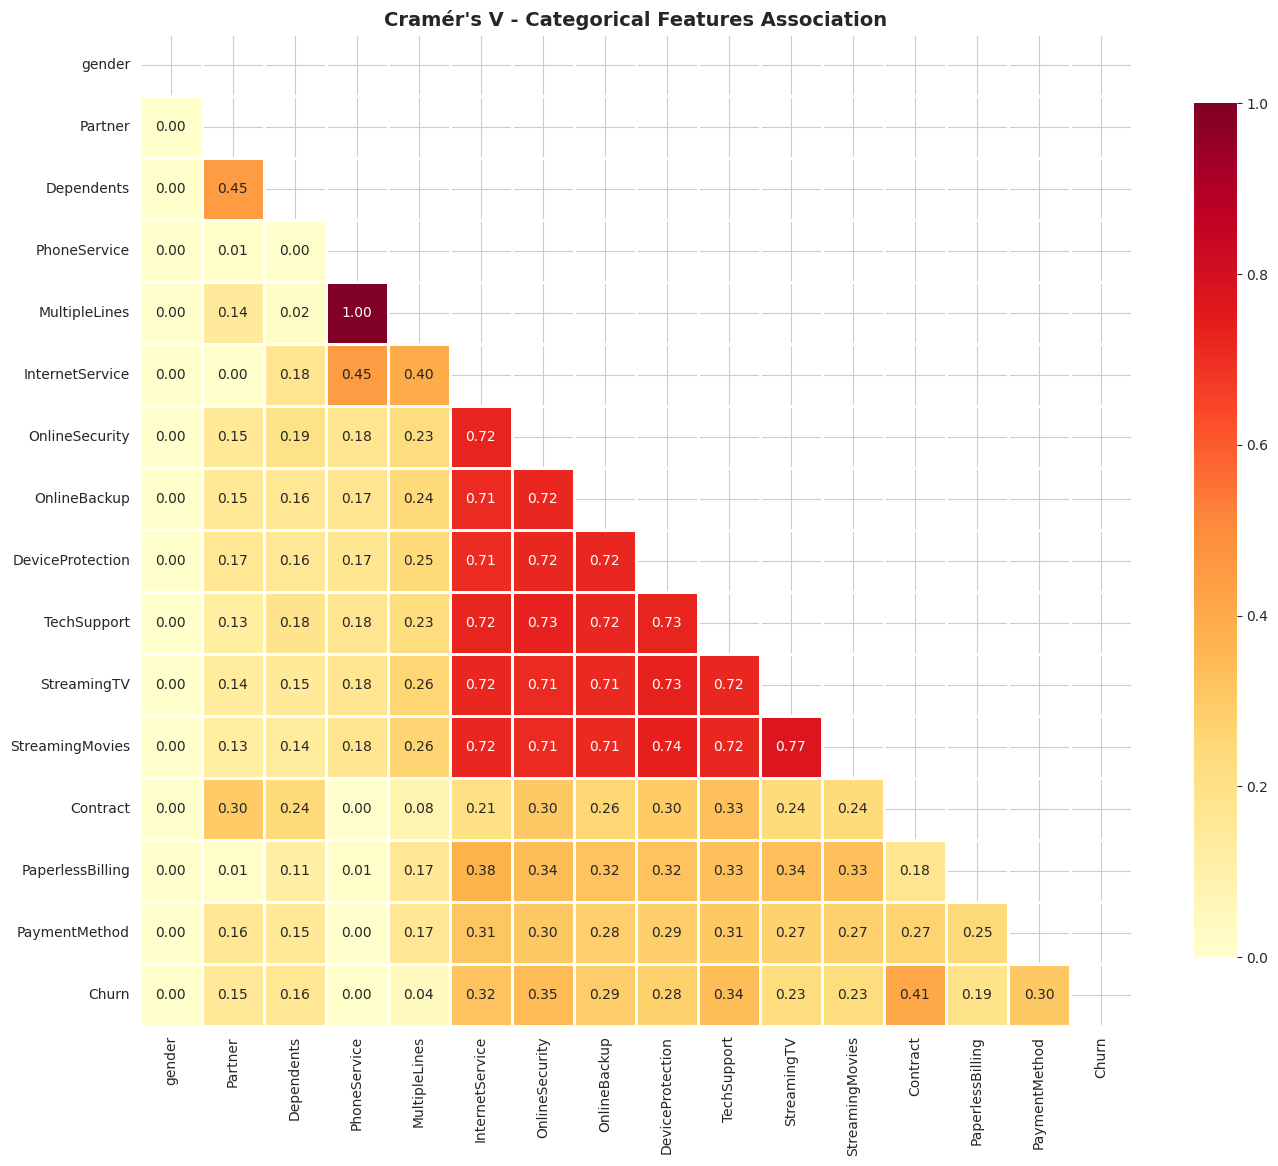

Categorical Features Association with Churn (Cramér's V):
Contract             : 0.410 (Strong)
OnlineSecurity       : 0.347 (Strong)
TechSupport          : 0.343 (Strong)
InternetService      : 0.322 (Strong)
PaymentMethod        : 0.303 (Strong)
OnlineBackup         : 0.292 (Moderate)
DeviceProtection     : 0.281 (Moderate)
StreamingMovies      : 0.230 (Moderate)
StreamingTV          : 0.230 (Moderate)
PaperlessBilling     : 0.191 (Weak)
Dependents           : 0.163 (Weak)
Partner              : 0.150 (Weak)
MultipleLines        : 0.036 (Weak)
PhoneService         : 0.000 (Weak)
gender               : 0.000 (Weak)


In [8]:
def cramers_v(x, y):
    """Calculating Cramér's V statistic for categorical association"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('customerID')

cramers_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers_matrix = cramers_matrix.astype(float)

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))
sns.heatmap(cramers_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='YlOrRd', vmin=0, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Cramér's V - Categorical Features Association", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

churn_associations = cramers_matrix.loc['Churn'].drop('Churn').sort_values(ascending=False)
print("Categorical Features Association with Churn (Cramér's V):")
print("=" * 50)
for feature, assoc in churn_associations.items():
    strength = 'Strong' if assoc > 0.3 else 'Moderate' if assoc > 0.2 else 'Weak'
    print(f"{feature:20} : {assoc:.3f} ({strength})")

### 5.3 Combined Feature Importance Ranking

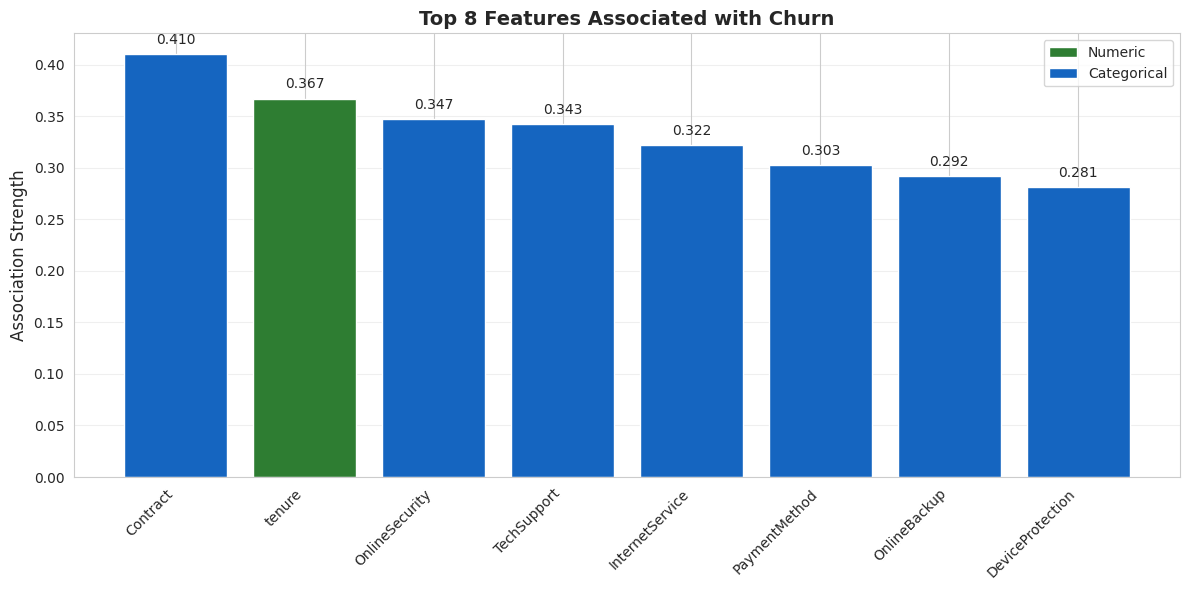


Key Insights:
- Strongest predictor: Contract (0.410)
- 7 categorical and 1 numeric features in top 8


In [9]:
all_associations = pd.DataFrame({
    'Feature': list(target_correlations.index) + list(churn_associations.index),
    'Association': list(target_correlations.values) + list(churn_associations.values),
    'Type': ['Numeric'] * len(target_correlations) + ['Categorical'] * len(churn_associations)
})

all_associations = all_associations.sort_values('Association', ascending=False)
top_features = all_associations.head(8)

plt.figure(figsize=(12, 6))
colors = ['#2e7d32' if t == 'Numeric' else '#1565c0' for t in top_features['Type']]
bars = plt.bar(range(len(top_features)), top_features['Association'], color=colors)
plt.xticks(range(len(top_features)), top_features['Feature'], rotation=45, ha='right')
plt.ylabel('Association Strength', fontsize=12)
plt.title('Top 8 Features Associated with Churn', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, top_features['Association']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', fontsize=10)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2e7d32', label='Numeric'),
                   Patch(facecolor='#1565c0', label='Categorical')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"- Strongest predictor: {top_features.iloc[0]['Feature']} ({top_features.iloc[0]['Association']:.3f})")
print(f"- {(top_features['Type'] == 'Categorical').sum()} categorical and {(top_features['Type'] == 'Numeric').sum()} numeric features in top 8")

## 6. Deep-Dive Exploratory Data Analysis

### 6.1 Churn Rate by Key Categorical Features

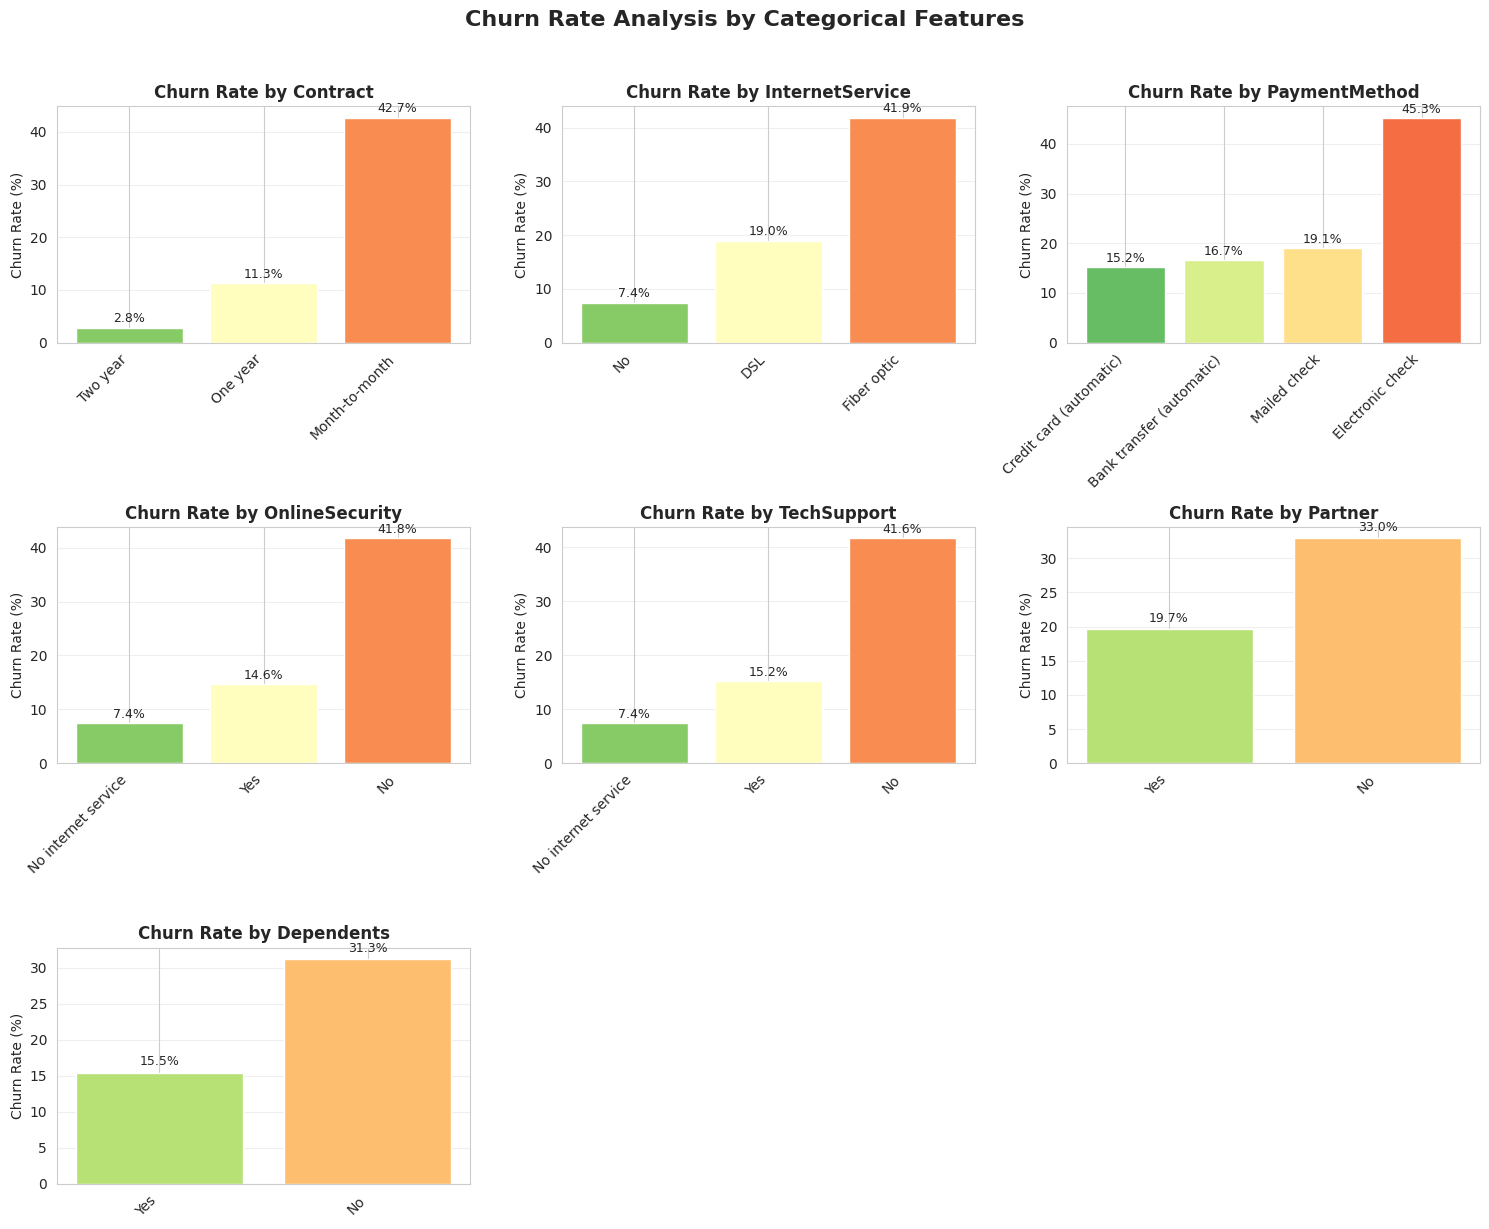

In [10]:
key_categorical = ['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity',
                   'TechSupport', 'Partner', 'Dependents']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(key_categorical[:7]):
    churn_rate = df.groupby(feature)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100).sort_values()

    ax = axes[idx]
    bars = ax.bar(range(len(churn_rate)), churn_rate.values,
                  color=sns.color_palette('RdYlGn_r', len(churn_rate)))
    ax.set_xticks(range(len(churn_rate)))
    ax.set_xticklabels(churn_rate.index, rotation=45, ha='right')
    ax.set_ylabel('Churn Rate (%)')
    ax.set_title(f'Churn Rate by {feature}', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars, churn_rate.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', fontsize=9)

for idx in range(7, 9):
    fig.delaxes(axes[idx])

plt.suptitle('Churn Rate Analysis by Categorical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 6.2 Distribution Analysis for Numeric Features

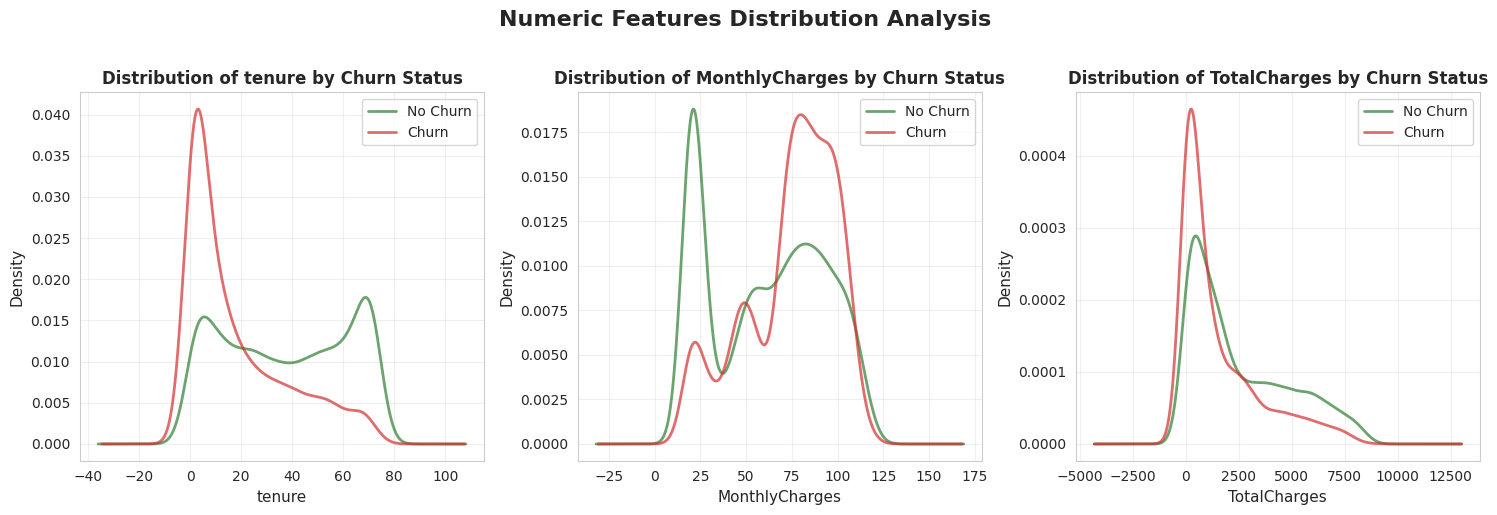

Statistical Comparison of Numeric Features by Churn Status

tenure:
  No Churn  - Mean: 37.57, Median: 38.00, Std: 24.11
  Churn     - Mean: 17.98, Median: 10.00, Std: 19.53
  Mann-Whitney U test p-value: 2.4196e-208
  Significant difference: Yes

MonthlyCharges:
  No Churn  - Mean: 61.27, Median: 64.43, Std: 31.09
  Churn     - Mean: 74.44, Median: 79.65, Std: 24.67
  Mann-Whitney U test p-value: 3.3116e-54
  Significant difference: Yes

TotalCharges:
  No Churn  - Mean: 2549.91, Median: 1679.53, Std: 2329.95
  Churn     - Mean: 1531.80, Median: 703.55, Std: 1890.82
  Mann-Whitney U test p-value: 5.6850e-83
  Significant difference: Yes


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

numeric_features_analysis = ['tenure', 'MonthlyCharges', 'TotalCharges']

for idx, feature in enumerate(numeric_features_analysis):
    ax = axes[idx]
    for churn_val, color, label in [('No', '#2e7d32', 'No Churn'), ('Yes', '#d32f2f', 'Churn')]:
        data = df[df['Churn'] == churn_val][feature]
        data.plot(kind='kde', ax=ax, label=label, color=color, linewidth=2, alpha=0.7)

    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Distribution of {feature} by Churn Status', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Numeric Features Distribution Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Statistical Comparison of Numeric Features by Churn Status")
print("=" * 70)
for feature in numeric_features_analysis:
    no_churn = df[df['Churn'] == 'No'][feature]
    yes_churn = df[df['Churn'] == 'Yes'][feature]

    print(f"\n{feature}:")
    print(f"  No Churn  - Mean: {no_churn.mean():.2f}, Median: {no_churn.median():.2f}, Std: {no_churn.std():.2f}")
    print(f"  Churn     - Mean: {yes_churn.mean():.2f}, Median: {yes_churn.median():.2f}, Std: {yes_churn.std():.2f}")

    statistic, pvalue = stats.mannwhitneyu(no_churn, yes_churn)
    print(f"  Mann-Whitney U test p-value: {pvalue:.4e}")
    print(f"  Significant difference: {'Yes' if pvalue < 0.05 else 'No'}")

### 6.3 Service Usage Pattern Analysis

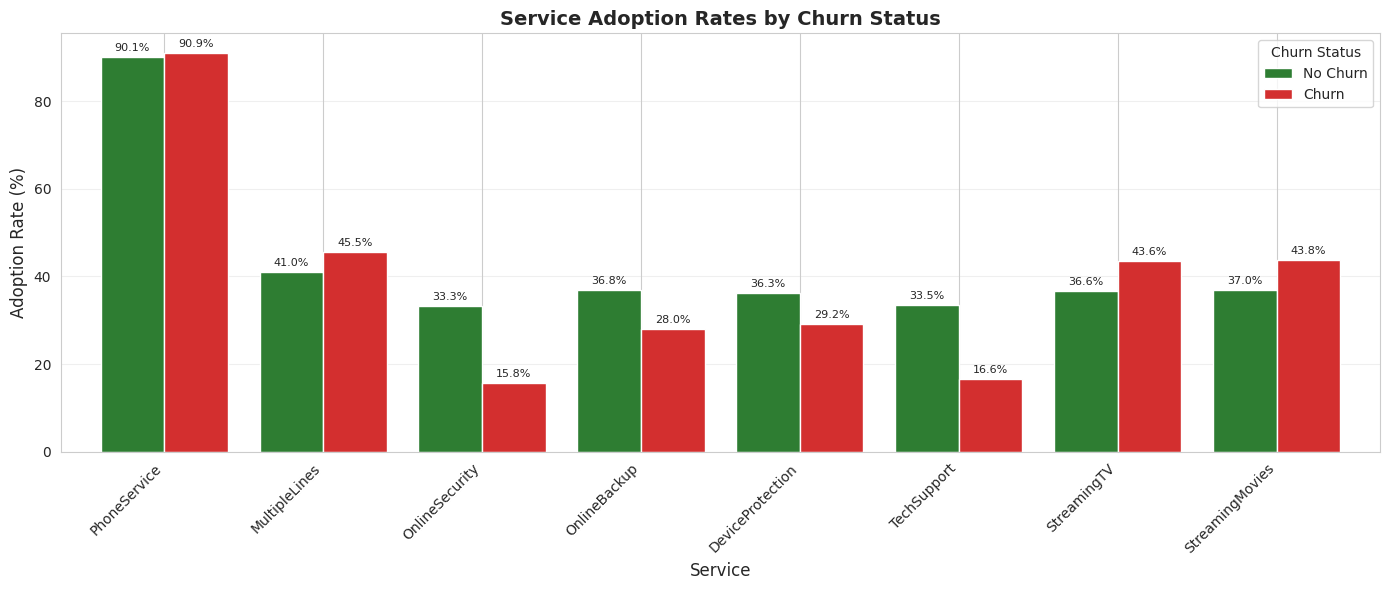

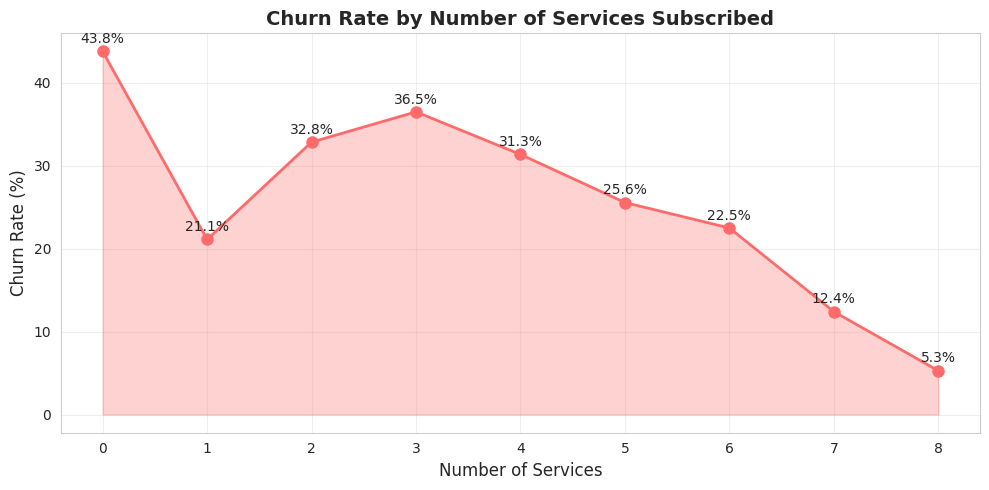

Key Service Insights:
- Customers with 8 services have lowest churn rate: 5.3%
- Customers with 0 services have highest churn rate: 43.8%


In [12]:
service_columns = ['PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

service_adoption = pd.DataFrame()
for service in service_columns:
    adoption = df.groupby('Churn')[service].value_counts(normalize=True).unstack(fill_value=0)
    if 'Yes' in adoption.columns:
        service_adoption[service] = adoption['Yes'] * 100

fig, ax = plt.subplots(figsize=(14, 6))
service_adoption.T.plot(kind='bar', ax=ax, color=['#2e7d32', '#d32f2f'], width=0.8)
ax.set_xlabel('Service', fontsize=12)
ax.set_ylabel('Adoption Rate (%)', fontsize=12)
ax.set_title('Service Adoption Rates by Churn Status', fontsize=14, fontweight='bold')
ax.legend(title='Churn Status', labels=['No Churn', 'Churn'])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=8)

plt.tight_layout()
plt.show()

df['TotalServices'] = df[service_columns].apply(lambda x: (x == 'Yes').sum(), axis=1)

churn_by_services = df.groupby('TotalServices')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

plt.figure(figsize=(10, 5))
ax = churn_by_services.plot(kind='line', marker='o', markersize=8, linewidth=2, color='#ff6b6b')
ax.fill_between(churn_by_services.index, churn_by_services.values, alpha=0.3, color='#ff6b6b')
plt.xlabel('Number of Services', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.title('Churn Rate by Number of Services Subscribed', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

for x, y in zip(churn_by_services.index, churn_by_services.values):
    plt.text(x, y + 1, f'{y:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Key Service Insights:")
print(f"- Customers with {churn_by_services.idxmin()} services have lowest churn rate: {churn_by_services.min():.1f}%")
print(f"- Customers with {churn_by_services.idxmax()} services have highest churn rate: {churn_by_services.max():.1f}%")

## 7. Multicollinearity Analysis with VIF

Variance Inflation Factor (VIF) helps identify multicollinearity among features.

📊 Variance Inflation Factor (VIF) Analysis


,Feature,VIF,Multicollinearity
3,TotalCharges,8.080935,Moderate
1,tenure,6.332627,Moderate
2,MonthlyCharges,3.694794,Low
0,SeniorCitizen,1.257276,Low


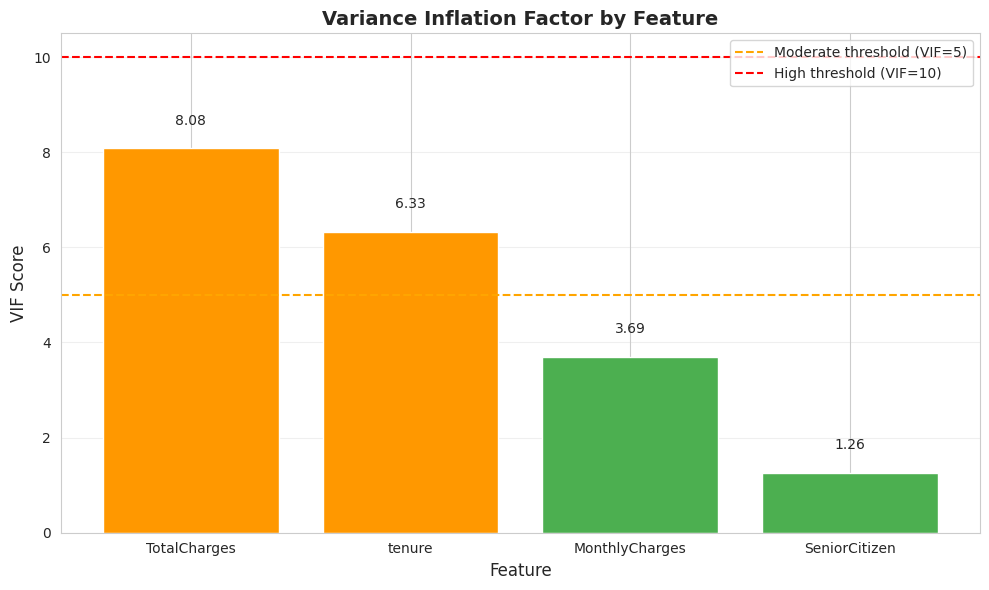


No severe multicollinearity detected (all VIF < 10)


In [13]:
vif_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
vif_data = df[vif_features]

vif_df = pd.DataFrame()
vif_df['Feature'] = vif_features
vif_df['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_features))]
vif_df = vif_df.sort_values('VIF', ascending=False)

vif_df['Multicollinearity'] = vif_df['VIF'].apply(
    lambda x: 'High' if x > 10 else 'Moderate' if x > 5 else 'Low'
)

print("📊 Variance Inflation Factor (VIF) Analysis")
print("=" * 50)
display(vif_df)

plt.figure(figsize=(10, 6))
colors = ['#d32f2f' if x > 10 else '#ff9800' if x > 5 else '#4caf50' for x in vif_df['VIF']]
bars = plt.bar(vif_df['Feature'], vif_df['VIF'], color=colors)
plt.axhline(y=5, color='orange', linestyle='--', label='Moderate threshold (VIF=5)')
plt.axhline(y=10, color='red', linestyle='--', label='High threshold (VIF=10)')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('VIF Score', fontsize=12)
plt.title('Variance Inflation Factor by Feature', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, vif_df['VIF']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

high_vif_features = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
if high_vif_features:
    print(f"\nHigh multicollinearity detected in: {', '.join(high_vif_features)}")
else:
    print("\nNo severe multicollinearity detected (all VIF < 10)")

## 8. Feature Engineering & Preprocessing Pipelines

Creating two feature sets based on multicollinearity analysis and model requirements.

In [14]:


all_features = df.columns.tolist()
all_features.remove('customerID')
all_features.remove('Churn')
all_features.remove('Churn_Binary')

features_to_drop_nonlinear = ['customerID', 'gender', 'PhoneService']
feature_set_1 = [col for col in all_features if col not in features_to_drop_nonlinear]

features_to_drop_linear = ['customerID', 'gender', 'PhoneService', 'TotalCharges']
feature_set_2 = [col for col in all_features if col not in features_to_drop_linear]

numeric_features_1 = [f for f in feature_set_1 if df[f].dtype in ['int64', 'float64']]
categorical_features_1 = [f for f in feature_set_1 if df[f].dtype == 'object']

numeric_features_2 = [f for f in feature_set_2 if df[f].dtype in ['int64', 'float64']]
categorical_features_2 = [f for f in feature_set_2 if df[f].dtype == 'object']


drop_reasons = {
    'customerID': "Unique identifier with no predictive value.",
    'gender': "No statistical correlation with Churn (Cramér's V = 0.000).",
    'PhoneService': "No statistical correlation with Churn (Cramér's V = 0.000).",
    'TotalCharges': "High multicollinearity with 'tenure' (Corr = 0.835), which can destabilize linear models."
}

print("Feature Set 1 (For Non-Linear Models):")
print(f"  Total features: {len(feature_set_1)}")
print(f"  Numeric: {len(numeric_features_1)} - {numeric_features_1}")
print(f"  Categorical: {len(categorical_features_1)} - {categorical_features_1}")
print("\n  Features Dropped & Reasons:")
for feature in features_to_drop_nonlinear:
    if feature in drop_reasons:
        print(f"    - {feature}: {drop_reasons[feature]}")

print("\n" + "="*50 + "\n")

print("Feature Set 2 (For Linear Models):")
print(f"  Total features: {len(feature_set_2)}")
print(f"  Numeric: {len(numeric_features_2)} - {numeric_features_2}")
print(f"  Categorical: {len(categorical_features_2)} - {categorical_features_2}")
print("\n  Features Dropped & Reasons:")
for feature in features_to_drop_linear:
    if feature in drop_reasons:
        print(f"    - {feature}: {drop_reasons[feature]}")


def create_preprocessor(numeric_features, categorical_features):
    """Create a preprocessing pipeline for the given features"""

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor

preprocessor_1 = create_preprocessor(numeric_features_1, categorical_features_1)
preprocessor_2 = create_preprocessor(numeric_features_2, categorical_features_2)

print("\nPreprocessing pipelines created successfully!")
print("   - Pipeline 1: For non-linear models (with TotalCharges)")
print("   - Pipeline 2: For linear models (without TotalCharges)")

Feature Set 1 (For Non-Linear Models):
  Total features: 18
  Numeric: 5 - ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']
  Categorical: 13 - ['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

  Features Dropped & Reasons:
    - customerID: Unique identifier with no predictive value.
    - gender: No statistical correlation with Churn (Cramér's V = 0.000).
    - PhoneService: No statistical correlation with Churn (Cramér's V = 0.000).


Feature Set 2 (For Linear Models):
  Total features: 17
  Numeric: 4 - ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalServices']
  Categorical: 13 - ['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMeth

## 9. Unsupervised Learning: K-Means Clustering

Identifying customer segments through clustering to better understand churn patterns.

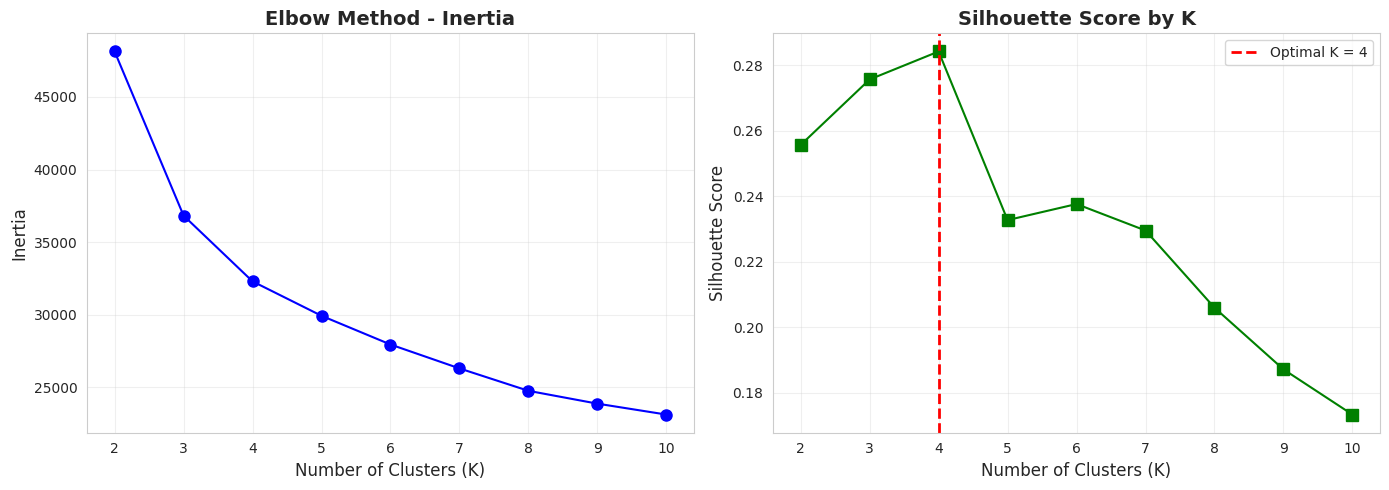


Optimal number of clusters selected: K = 4
   Silhouette Score at K=4: 0.284


In [15]:
X_clustering = df[feature_set_1].copy()
y_clustering = df['Churn_Binary'].copy()

X_clustering_scaled = preprocessor_1.fit_transform(X_clustering)

inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_clustering_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'b-', marker='o', markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'g-', marker='s', markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]

axes[1].axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K = {optimal_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nOptimal number of clusters selected: K = {optimal_k}")

optimal_score = silhouette_scores[K_range.index(optimal_k)]
print(f"   Silhouette Score at K={optimal_k}: {optimal_score:.3f}")


Cluster Profile Analysis


,Cluster,Size,Size_pct,Churn_Rate,Avg_Tenure,Avg_MonthlyCharges,Avg_TotalCharges,Most_Common_Contract,Most_Common_Payment
0,0,1988,28.226608,13.631791,58.137324,90.715669,5267.490267,Two year,Bank transfer (automatic)
1,1,1526,21.666903,7.404980,30.547182,21.079194,662.604784,Two year,Mailed check
2,2,891,12.650859,49.494949,25.684624,78.442368,2074.295062,Month-to-month,Electronic check
3,3,2638,37.455630,39.575436,16.267248,65.850967,1033.004644,Month-to-month,Electronic check


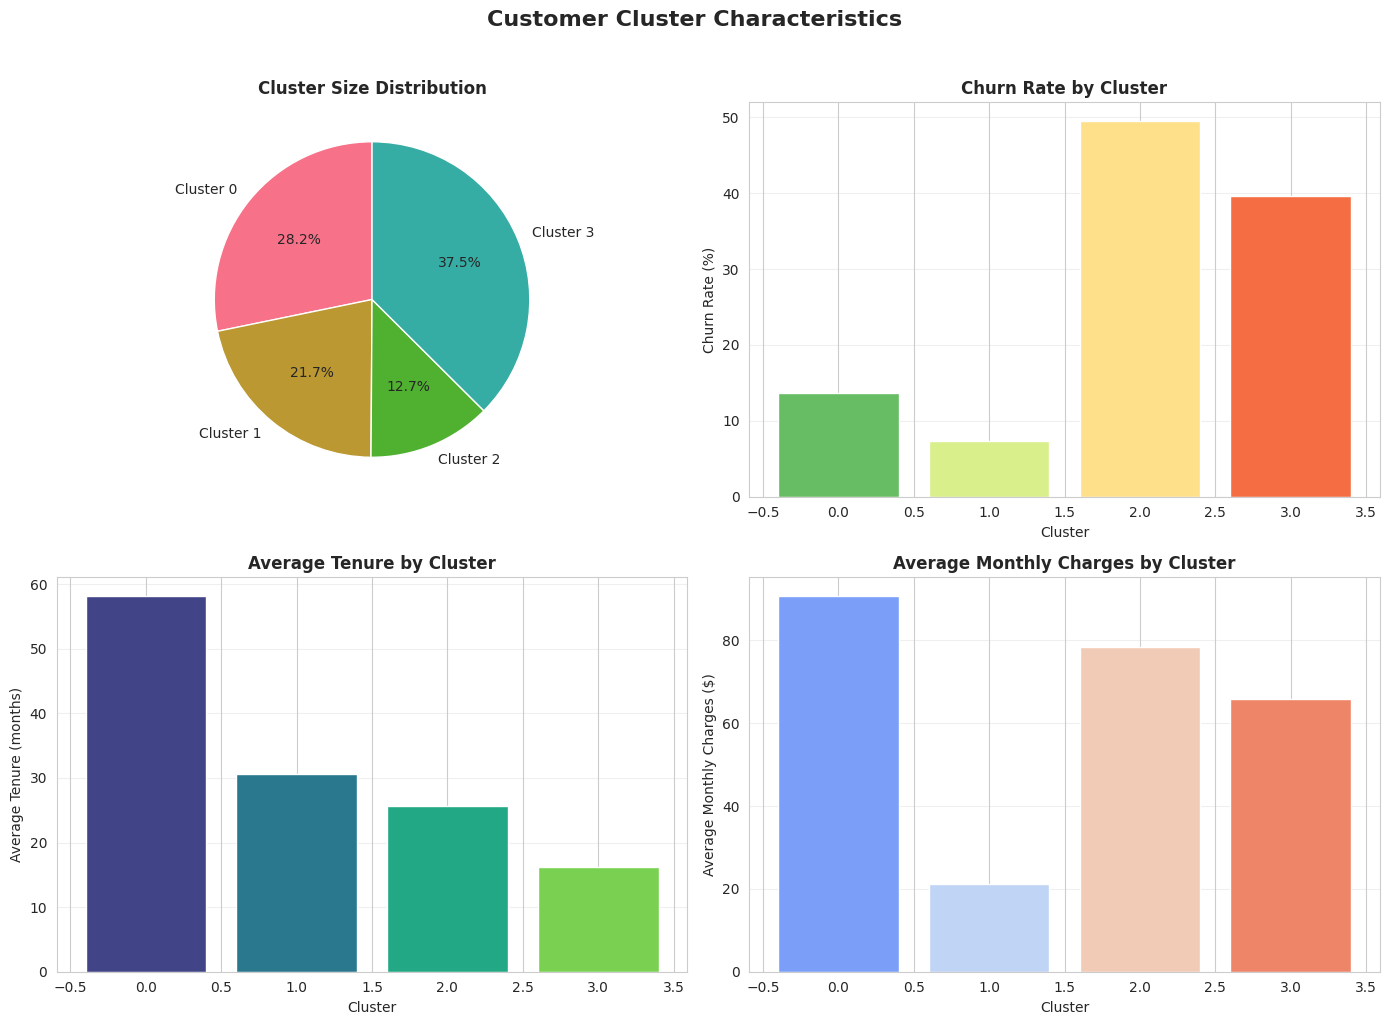


Customer Personas Based on Clustering:

Cluster 0:
  Risk Level: LOW RISK (Churn Rate: 13.6%)
  Size: 1988 customers (28.2%)
  Profile: 58 months tenure, $90.72/month
  Preferred: Two year contract, Bank transfer (automatic) payment

Cluster 1:
  Risk Level: LOW RISK (Churn Rate: 7.4%)
  Size: 1526 customers (21.7%)
  Profile: 31 months tenure, $21.08/month
  Preferred: Two year contract, Mailed check payment

Cluster 2:
  Risk Level: HIGH RISK (Churn Rate: 49.5%)
  Size: 891 customers (12.7%)
  Profile: 26 months tenure, $78.44/month
  Preferred: Month-to-month contract, Electronic check payment

Cluster 3:
  Risk Level: MEDIUM RISK (Churn Rate: 39.6%)
  Size: 2638 customers (37.5%)
  Profile: 16 months tenure, $65.85/month
  Preferred: Month-to-month contract, Electronic check payment


In [16]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clustering_scaled)

df['Cluster'] = cluster_labels
cluster_analysis = pd.DataFrame()

for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]

    cluster_stats = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Size_pct': len(cluster_data) / len(df) * 100,
        'Churn_Rate': (cluster_data['Churn'] == 'Yes').mean() * 100,
        'Avg_Tenure': cluster_data['tenure'].mean(),
        'Avg_MonthlyCharges': cluster_data['MonthlyCharges'].mean(),
        'Avg_TotalCharges': cluster_data['TotalCharges'].mean(),
        'Most_Common_Contract': cluster_data['Contract'].mode()[0],
        'Most_Common_Payment': cluster_data['PaymentMethod'].mode()[0]
    }

    cluster_analysis = pd.concat([cluster_analysis, pd.DataFrame([cluster_stats])], ignore_index=True)

print("\nCluster Profile Analysis")
print("=" * 80)
display(cluster_analysis)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].pie(cluster_analysis['Size'], labels=[f'Cluster {i}' for i in range(optimal_k)],
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')

axes[0, 1].bar(cluster_analysis['Cluster'], cluster_analysis['Churn_Rate'],
               color=sns.color_palette('RdYlGn_r', optimal_k))
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Churn Rate (%)')
axes[0, 1].set_title('Churn Rate by Cluster', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

axes[1, 0].bar(cluster_analysis['Cluster'], cluster_analysis['Avg_Tenure'],
               color=sns.color_palette('viridis', optimal_k))
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Average Tenure (months)')
axes[1, 0].set_title('Average Tenure by Cluster', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].bar(cluster_analysis['Cluster'], cluster_analysis['Avg_MonthlyCharges'],
               color=sns.color_palette('coolwarm', optimal_k))
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Average Monthly Charges ($)')
axes[1, 1].set_title('Average Monthly Charges by Cluster', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Customer Cluster Characteristics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nCustomer Personas Based on Clustering:")
print("=" * 60)
for idx, row in cluster_analysis.iterrows():
    print(f"\nCluster {int(row['Cluster'])}:")
    if row['Churn_Rate'] > 40:
        risk = "HIGH RISK"
    elif row['Churn_Rate'] > 25:
        risk = "MEDIUM RISK"
    else:
        risk = "LOW RISK"
    print(f"  Risk Level: {risk} (Churn Rate: {row['Churn_Rate']:.1f}%)")
    print(f"  Size: {row['Size']} customers ({row['Size_pct']:.1f}%)")
    print(f"  Profile: {row['Avg_Tenure']:.0f} months tenure, ${row['Avg_MonthlyCharges']:.2f}/month")
    print(f"  Preferred: {row['Most_Common_Contract']} contract, {row['Most_Common_Payment']} payment")

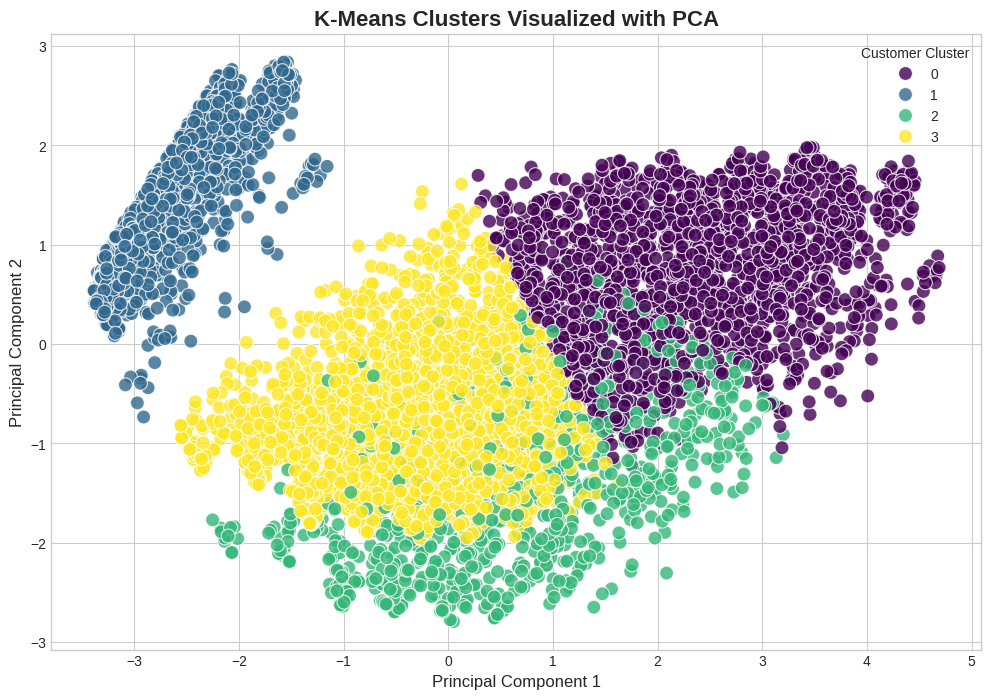

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['PCA_1', 'PCA_2'])
df_pca['Cluster'] = df['Cluster']

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA_1',
    y='PCA_2',
    hue='Cluster',
    data=df_pca,
    palette='viridis',
    s=100,
    alpha=0.8
)

plt.title('K-Means Clusters Visualized with PCA', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Customer Cluster')
plt.grid(True)
plt.show()

## 10. Data Splitting and Balancing Strategies

Implementing two different balancing strategies to handle class imbalance.

In [18]:
X = df[feature_set_1]
y = df['Churn_Binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

train_indices = X_train.index
train_clusters = df.loc[train_indices, 'Cluster']

print("Data Split Summary:")
print("=" * 50)
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nClass distribution in training:")
print(y_train.value_counts())
print(f"\nClass distribution in test:")
print(y_test.value_counts())

preprocessor_1.fit(X_train)
preprocessor_2.fit(X_train[feature_set_2])

print("\nPreprocessors fitted on training data only (preventing data leakage)")

Data Split Summary:
Training set: 4930 samples (70.0%)
Test set: 2113 samples (30.0%)

Class distribution in training:
Churn_Binary
0    3622
1    1308
Name: count, dtype: int64

Class distribution in test:
Churn_Binary
0    1552
1     561
Name: count, dtype: int64

Preprocessors fitted on training data only (preventing data leakage)


In [19]:
print("Strategy A: Cluster-Based Undersampling")
print("=" * 50)

train_df = pd.DataFrame(X_train)
train_df['Churn'] = y_train
train_df['Cluster'] = train_clusters

minority_class_size = (y_train == 1).sum()
majority_class_size = (y_train == 0).sum()

balanced_indices_cluster = []
minority_indices = train_df[train_df['Churn'] == 1].index.tolist()
balanced_indices_cluster.extend(minority_indices)

for cluster in train_df['Cluster'].unique():
    cluster_majority = train_df[(train_df['Cluster'] == cluster) & (train_df['Churn'] == 0)]
    cluster_weight = len(cluster_majority) / majority_class_size
    n_samples = int(minority_class_size * cluster_weight)

    if n_samples > 0:
        sampled = cluster_majority.sample(n=min(n_samples, len(cluster_majority)),
                                         random_state=RANDOM_STATE)
        balanced_indices_cluster.extend(sampled.index.tolist())

X_train_cluster = X_train.loc[balanced_indices_cluster]
y_train_cluster = y_train.loc[balanced_indices_cluster]

print(f"Original training size: {len(X_train)}")
print(f"Balanced training size: {len(X_train_cluster)}")
print(f"Class distribution after cluster-based undersampling:")
print(y_train_cluster.value_counts())
print(f"Balance ratio: {y_train_cluster.value_counts()[0] / y_train_cluster.value_counts()[1]:.2f}:1")

Strategy A: Cluster-Based Undersampling
Original training size: 4930
Balanced training size: 2613
Class distribution after cluster-based undersampling:
Churn_Binary
1    1308
0    1305
Name: count, dtype: int64
Balance ratio: 1.00:1


In [20]:
print("\nStrategy B: SMOTE Oversampling")
print("=" * 50)

X_train_transformed = preprocessor_1.transform(X_train)
smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy='auto')
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

print(f"Original training size: {len(X_train)}")
print(f"Balanced training size: {len(X_train_smote)}")
print(f"Class distribution after SMOTE:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count}")
print(f"Balance ratio: {counts[0] / counts[1]:.2f}:1")

X_train_cluster_transformed = preprocessor_1.transform(X_train_cluster)


Strategy B: SMOTE Oversampling
Original training size: 4930
Balanced training size: 7244
Class distribution after SMOTE:
  Class 0: 3622
  Class 1: 3622
Balance ratio: 1.00:1


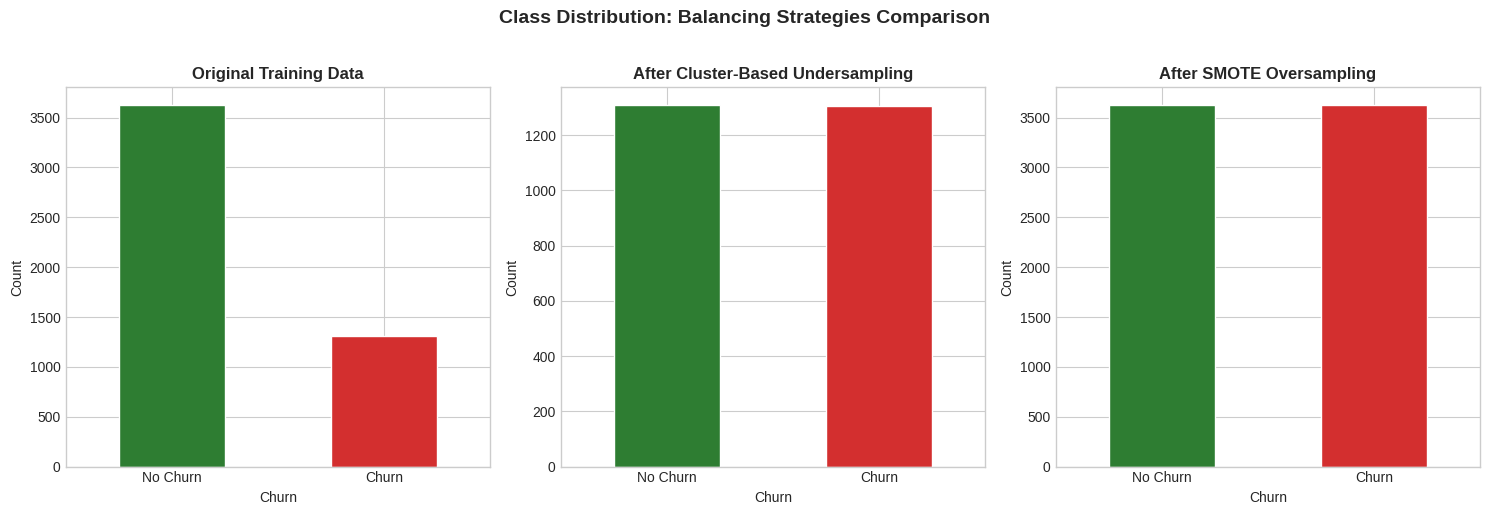

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['#2e7d32', '#d32f2f'])
axes[0].set_title('Original Training Data', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Churn', 'Churn'], rotation=0)

y_train_cluster.value_counts().plot(kind='bar', ax=axes[1], color=['#2e7d32', '#d32f2f'])
axes[1].set_title('After Cluster-Based Undersampling', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Churn', 'Churn'], rotation=0)

pd.Series(y_train_smote).value_counts().plot(kind='bar', ax=axes[2], color=['#2e7d32', '#d32f2f'])
axes[2].set_title('After SMOTE Oversampling', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Churn')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(['No Churn', 'Churn'], rotation=0)

plt.suptitle('Class Distribution: Balancing Strategies Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 11. Model Training with Cross-Validation

Training multiple models on both balanced datasets with 5-fold cross-validation.

In [22]:
models = {
    'Logistic Regression': (LogisticRegression(random_state=RANDOM_STATE, max_iter=1000), 'linear'),
    'Decision Tree': (DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5), 'nonlinear'),
    'Gaussian Naive Bayes': (GaussianNB(), 'nonlinear'),
    'K-Nearest Neighbors': (KNeighborsClassifier(n_neighbors=5), 'nonlinear'),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100, 50), random_state=RANDOM_STATE, max_iter=1000), 'nonlinear')
}

X_test_transformed_1 = preprocessor_1.transform(X_test)
X_test_transformed_2 = preprocessor_2.transform(X_test[feature_set_2])

X_train_cluster_transformed_2 = preprocessor_2.transform(X_train_cluster[feature_set_2])
X_train_transformed_2 = preprocessor_2.transform(X_train)
X_train_smote_2, y_train_smote_2 = smote.fit_resample(X_train_transformed_2, y_train)

print("All data prepared for model training")
print(f"   - Models to train: {len(models)}")
print(f"   - Balancing strategies: 2 (Cluster-based, SMOTE)")
print(f"   - Total model-strategy combinations: {len(models) * 2}")

All data prepared for model training
   - Models to train: 5
   - Balancing strategies: 2 (Cluster-based, SMOTE)
   - Total model-strategy combinations: 10


In [23]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, cv_folds=5):
    """Train model with cross-validation and evaluate on test set"""

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    metrics = {
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }

    return model, metrics, y_pred, y_pred_proba

results = {}
trained_models = {}

print("Training Models with 5-Fold Cross-Validation")
print("=" * 60)

for model_name, (model, model_type) in models.items():
    print(f"\nTraining {model_name}...")

    if model_type == 'linear':
        X_test_use = X_test_transformed_2

        model_cluster = model.__class__(**model.get_params())
        trained_model_cluster, metrics_cluster, _, _ = train_and_evaluate_model(
            model_cluster, X_train_cluster_transformed_2, y_train_cluster, X_test_use, y_test
        )

        model_smote = model.__class__(**model.get_params())
        trained_model_smote, metrics_smote, _, _ = train_and_evaluate_model(
            model_smote, X_train_smote_2, y_train_smote_2, X_test_use, y_test
        )
    else:
        X_test_use = X_test_transformed_1

        model_cluster = model.__class__(**model.get_params())
        trained_model_cluster, metrics_cluster, _, _ = train_and_evaluate_model(
            model_cluster, X_train_cluster_transformed, y_train_cluster, X_test_use, y_test
        )

        model_smote = model.__class__(**model.get_params())
        trained_model_smote, metrics_smote, _, _ = train_and_evaluate_model(
            model_smote, X_train_smote, y_train_smote, X_test_use, y_test
        )

    results[f"{model_name}_Cluster"] = metrics_cluster
    results[f"{model_name}_SMOTE"] = metrics_smote
    trained_models[f"{model_name}_Cluster"] = (trained_model_cluster, X_test_use)
    trained_models[f"{model_name}_SMOTE"] = (trained_model_smote, X_test_use)

    print(f"  Cluster-based - CV Accuracy: {metrics_cluster['cv_accuracy_mean']:.3f} ± {metrics_cluster['cv_accuracy_std']:.3f}")
    print(f"  SMOTE - CV Accuracy: {metrics_smote['cv_accuracy_mean']:.3f} ± {metrics_smote['cv_accuracy_std']:.3f}")

results_df = pd.DataFrame(results).T
results_df = results_df.round(3)
results_df.index.name = 'Model_Strategy'

print("\nInitial Model Performance Summary")
print("=" * 80)
display(results_df.sort_values('test_accuracy', ascending=False))

Training Models with 5-Fold Cross-Validation

Training Logistic Regression...
  Cluster-based - CV Accuracy: 0.755 ± 0.016
  SMOTE - CV Accuracy: 0.769 ± 0.010

Training Decision Tree...
  Cluster-based - CV Accuracy: 0.755 ± 0.011
  SMOTE - CV Accuracy: 0.777 ± 0.011

Training Gaussian Naive Bayes...
  Cluster-based - CV Accuracy: 0.729 ± 0.013
  SMOTE - CV Accuracy: 0.740 ± 0.010

Training K-Nearest Neighbors...
  Cluster-based - CV Accuracy: 0.718 ± 0.014
  SMOTE - CV Accuracy: 0.791 ± 0.004

Training Neural Network...
  Cluster-based - CV Accuracy: 0.703 ± 0.022
  SMOTE - CV Accuracy: 0.833 ± 0.013

Initial Model Performance Summary


,cv_accuracy_mean,cv_accuracy_std,test_accuracy,precision,recall,f1,auc
Model_Strategy,,,,,,,
Logistic Regression_Cluster,0.755,0.016,0.747,0.515,0.799,0.626,0.841
Decision Tree_SMOTE,0.777,0.011,0.747,0.516,0.758,0.614,0.825
Logistic Regression_SMOTE,0.769,0.010,0.746,0.515,0.775,0.619,0.842
Neural Network_SMOTE,0.833,0.013,0.745,0.519,0.553,0.535,0.774
K-Nearest Neighbors_SMOTE,0.791,0.004,0.702,0.462,0.742,0.569,0.774
Decision Tree_Cluster,0.755,0.011,0.702,0.466,0.840,0.600,0.818
K-Nearest Neighbors_Cluster,0.718,0.014,0.696,0.457,0.777,0.576,0.783
Neural Network_Cluster,0.703,0.022,0.681,0.440,0.734,0.550,0.753
Gaussian Naive Bayes_SMOTE,0.740,0.010,0.658,0.429,0.863,0.573,0.810


## 12. Business-Driven Threshold Optimization

Optimizing decision thresholds based on business costs:
- True Negative (TN): $0 (correctly identified non-churners)
- False Negative (FN): -$100 (missed churners - lost revenue)
- True Positive (TP): +$20 (correctly identified churners - retention success)
- False Positive (FP): -$10 (unnecessary retention efforts)

In [24]:
def calculate_business_score(y_true, y_pred):
    """Calculate business-weighted score based on confusion matrix"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = (tn * 0) + (fn * -100) + (tp * 20) + (fp * -10)
    return score, tn, fp, fn, tp

def optimize_threshold(model, X_test, y_test, thresholds=np.arange(0.05, 0.96, 0.05)):
    """Find optimal threshold that maximizes business score"""

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    scores = []
    metrics_list = []

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        score, tn, fp, fn, tp = calculate_business_score(y_test, y_pred)

        scores.append(score)
        metrics_list.append({
            'threshold': threshold,
            'score': score,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred),
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
        })

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_metrics = metrics_list[optimal_idx]

    return optimal_threshold, optimal_metrics, scores, thresholds

threshold_results = {}
optimization_curves = {}

print("Business-Driven Threshold Optimization")
print("=" * 60)
print("Business Cost Matrix:")
print("  True Negative (TN):  $0")
print("  False Negative (FN): -$100 (missed churner)")
print("  True Positive (TP):  +$20 (successful retention)")
print("  False Positive (FP): -$10 (unnecessary retention cost)")
print("\nOptimizing thresholds...\n")

for model_key, (model, X_test_use) in trained_models.items():
    optimal_threshold, optimal_metrics, scores, thresholds = optimize_threshold(
        model, X_test_use, y_test
    )

    threshold_results[model_key] = {
        'optimal_threshold': optimal_threshold,
        'business_score': optimal_metrics['score'],
        'accuracy': optimal_metrics['accuracy'],
        'precision': optimal_metrics['precision'],
        'recall': optimal_metrics['recall'],
        'confusion_matrix': (optimal_metrics['tn'], optimal_metrics['fp'],
                           optimal_metrics['fn'], optimal_metrics['tp'])
    }

    optimization_curves[model_key] = (scores, thresholds)

    print(f"{model_key:30} - Optimal Threshold: {optimal_threshold:.2f}, Score: ${optimal_metrics['score']:.0f}")

Business-Driven Threshold Optimization
Business Cost Matrix:
  True Negative (TN):  $0
  False Negative (FN): -$100 (missed churner)
  True Positive (TP):  +$20 (successful retention)
  False Positive (FP): -$10 (unnecessary retention cost)

Optimizing thresholds...

Logistic Regression_Cluster    - Optimal Threshold: 0.20, Score: $-160
Logistic Regression_SMOTE      - Optimal Threshold: 0.20, Score: $160
Decision Tree_Cluster          - Optimal Threshold: 0.25, Score: $60
Decision Tree_SMOTE            - Optimal Threshold: 0.20, Score: $140
Gaussian Naive Bayes_Cluster   - Optimal Threshold: 0.10, Score: $-2850
Gaussian Naive Bayes_SMOTE     - Optimal Threshold: 0.05, Score: $-3090
K-Nearest Neighbors_Cluster    - Optimal Threshold: 0.05, Score: $-1760
K-Nearest Neighbors_SMOTE      - Optimal Threshold: 0.05, Score: $-2430
Neural Network_Cluster         - Optimal Threshold: 0.05, Score: $-5020
Neural Network_SMOTE           - Optimal Threshold: 0.05, Score: $-9810


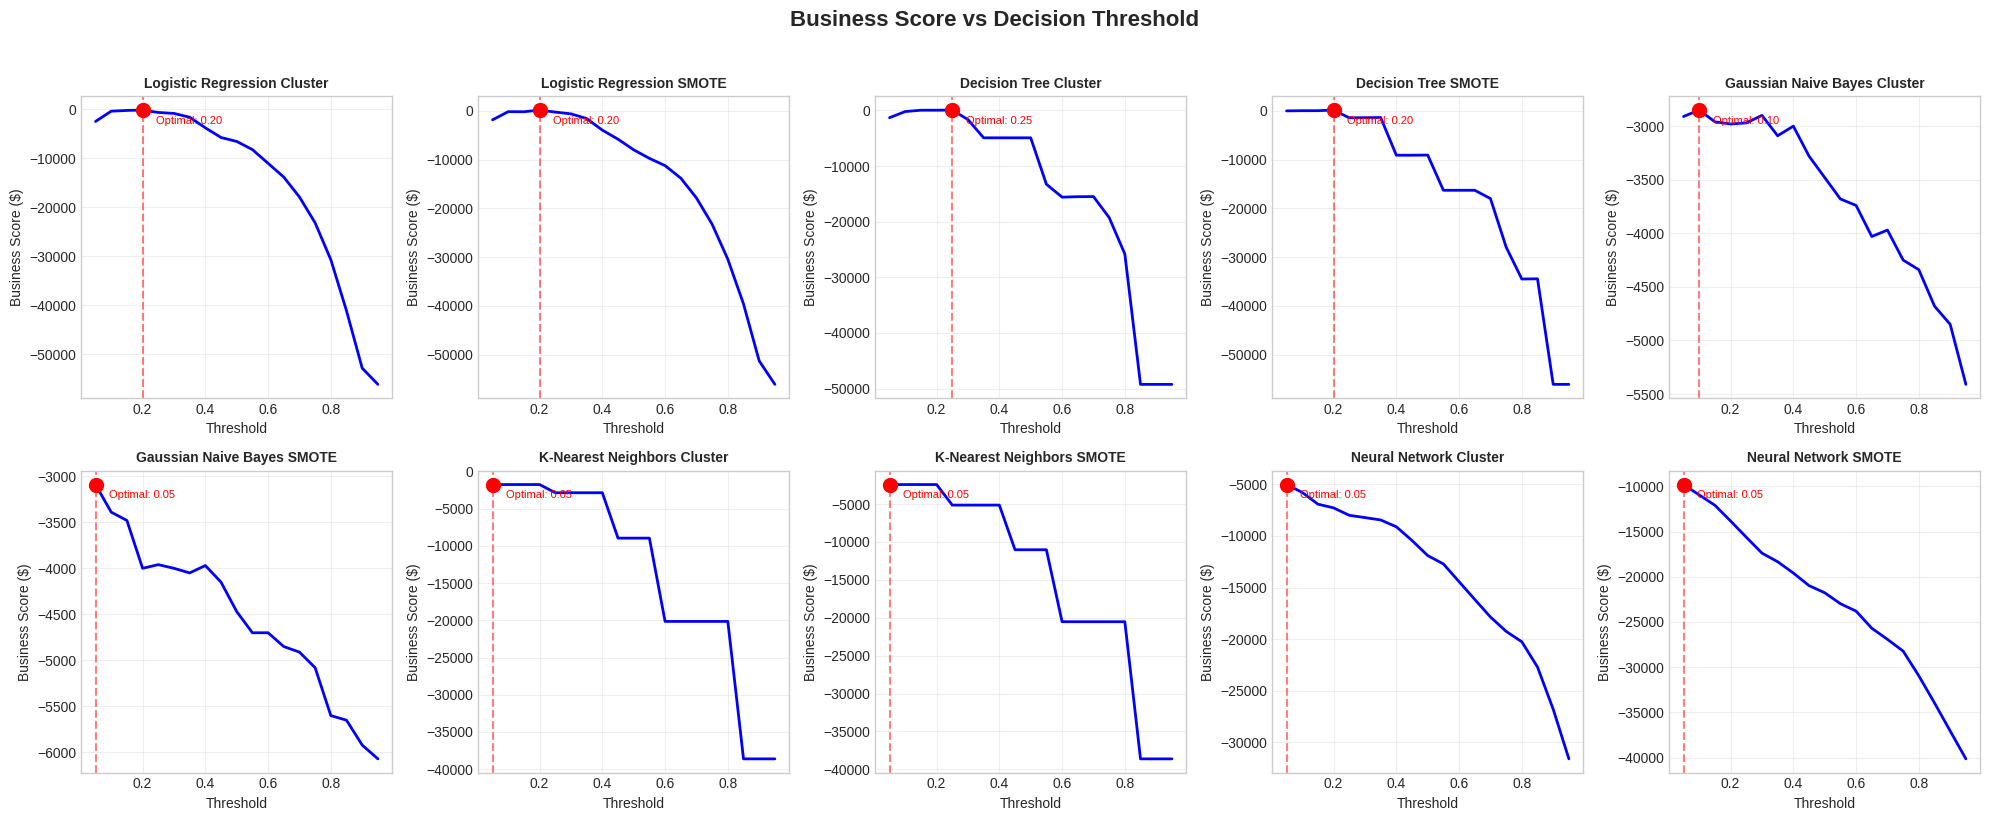

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (model_key, (scores, thresholds)) in enumerate(optimization_curves.items()):
    ax = axes[idx]
    ax.plot(thresholds, scores, 'b-', linewidth=2)

    optimal_idx = np.argmax(scores)
    ax.plot(thresholds[optimal_idx], scores[optimal_idx], 'ro', markersize=10)
    ax.axvline(x=thresholds[optimal_idx], color='r', linestyle='--', alpha=0.5)

    ax.set_xlabel('Threshold', fontsize=10)
    ax.set_ylabel('Business Score ($)', fontsize=10)
    ax.set_title(model_key.replace('_', ' '), fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

    ax.annotate(f'Optimal: {thresholds[optimal_idx]:.2f}',
                xy=(thresholds[optimal_idx], scores[optimal_idx]),
                xytext=(10, -10), textcoords='offset points',
                fontsize=8, color='red')

plt.suptitle('Business Score vs Decision Threshold', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 13. Model Comparison and Selection

Comprehensive comparison of all models to select the best performer.

In [26]:
comparison_data = []

for model_key in threshold_results.keys():
    model_name, strategy = model_key.rsplit('_', 1)

    comparison_data.append({
        'Model': model_name,
        'Balancing': strategy,
        'Optimal_Threshold': threshold_results[model_key]['optimal_threshold'],
        'Business_Score': threshold_results[model_key]['business_score'],
        'Accuracy': threshold_results[model_key]['accuracy'],
        'Precision': threshold_results[model_key]['precision'],
        'Recall': threshold_results[model_key]['recall'],
        'AUC': results[model_key]['auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Business_Score', ascending=False)

print("📊 Final Model Comparison (Sorted by Business Score)")
print("=" * 100)
display(comparison_df.style.background_gradient(subset=['Business_Score'], cmap='RdYlGn')
        .format({'Optimal_Threshold': '{:.2f}', 'Business_Score': '${:.0f}',
                'Accuracy': '{:.3f}', 'Precision': '{:.3f}',
                'Recall': '{:.3f}', 'AUC': '{:.3f}'}))

best_model_idx = comparison_df['Business_Score'].idxmax()
best_model = comparison_df.loc[best_model_idx]

print("\nBEST MODEL SELECTED:")
print("=" * 50)
print(f"Model: {best_model['Model']}")
print(f"Balancing Strategy: {best_model['Balancing']}")
print(f"Optimal Threshold: {best_model['Optimal_Threshold']:.2f}")
print(f"Business Score: ${best_model['Business_Score']:.0f}")
print(f"Recall (Sensitivity): {best_model['Recall']:.3f}")
print(f"Precision: {best_model['Precision']:.3f}")
print(f"Overall Accuracy: {best_model['Accuracy']:.3f}")

📊 Final Model Comparison (Sorted by Business Score)


,Model,Balancing,Optimal_Threshold,Business_Score,Accuracy,Precision,Recall,AUC
1,Logistic Regression,SMOTE,0.20,$160,0.602,0.396,0.957,0.842
3,Decision Tree,SMOTE,0.20,$140,0.585,0.387,0.963,0.825
2,Decision Tree,Cluster,0.25,$60,0.576,0.382,0.964,0.818
0,Logistic Regression,Cluster,0.20,$-160,0.581,0.384,0.959,0.841
6,K-Nearest Neighbors,Cluster,0.05,$-1760,0.490,0.338,0.964,0.783
7,K-Nearest Neighbors,SMOTE,0.05,$-2430,0.588,0.385,0.920,0.774
4,Gaussian Naive Bayes,Cluster,0.10,$-2850,0.615,0.400,0.904,0.810
5,Gaussian Naive Bayes,SMOTE,0.05,$-3090,0.630,0.410,0.895,0.810
8,Neural Network,Cluster,0.05,$-5020,0.580,0.376,0.881,0.753
9,Neural Network,SMOTE,0.05,$-9810,0.681,0.443,0.768,0.774



BEST MODEL SELECTED:
Model: Logistic Regression
Balancing Strategy: SMOTE
Optimal Threshold: 0.20
Business Score: $160
Recall (Sensitivity): 0.957
Precision: 0.396
Overall Accuracy: 0.602


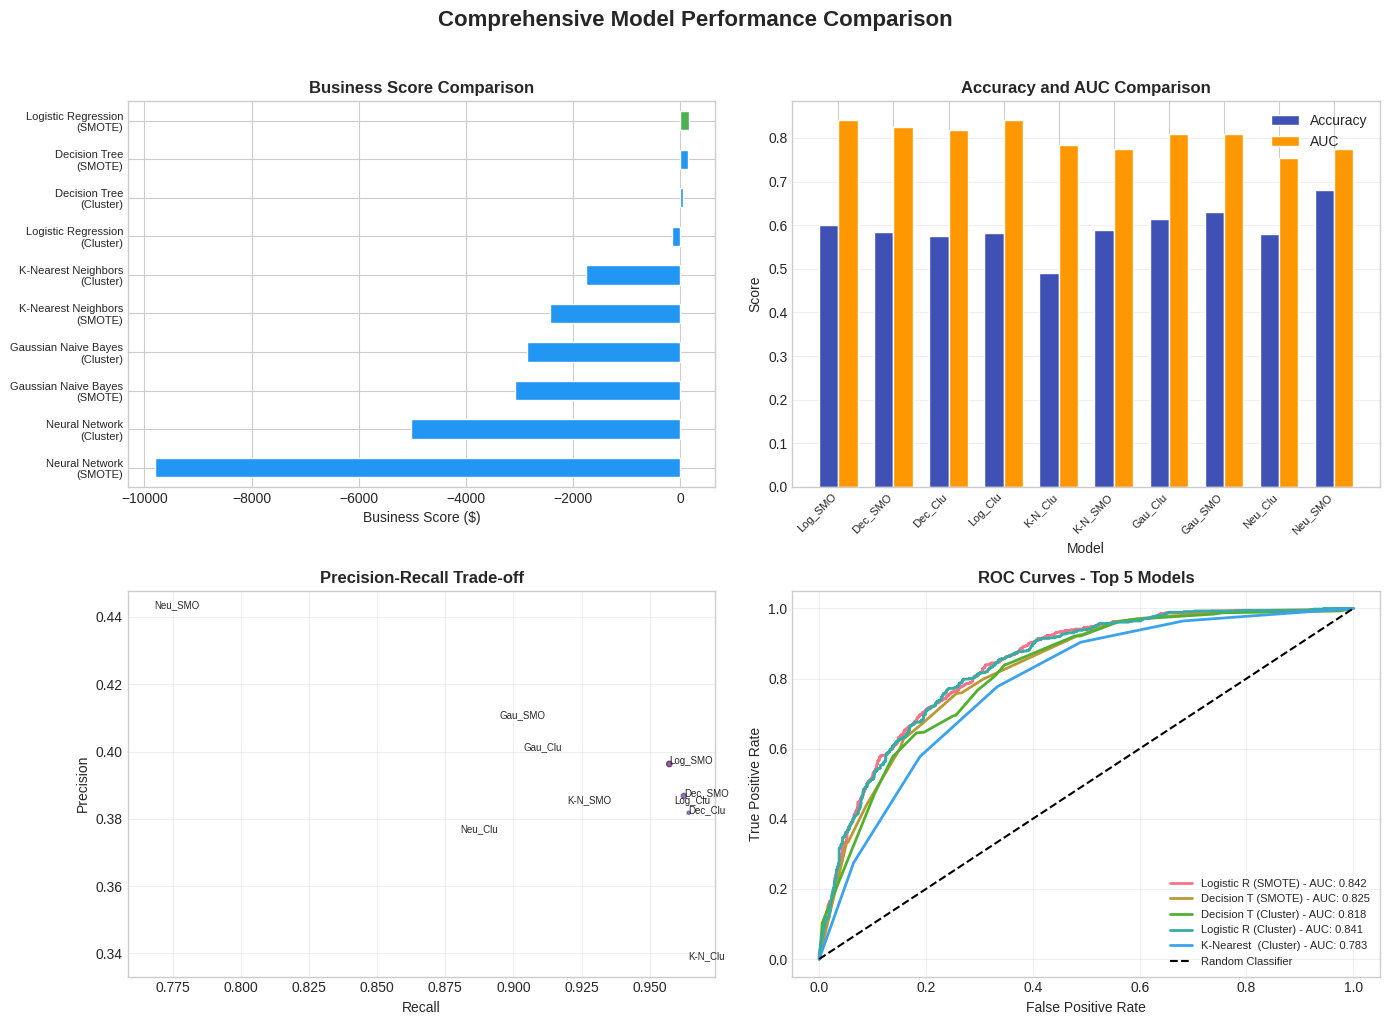

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
comparison_df_sorted = comparison_df.sort_values('Business_Score', ascending=True)
colors = ['#4caf50' if score == comparison_df['Business_Score'].max() else '#2196f3'
          for score in comparison_df_sorted['Business_Score']]
comparison_df_sorted['Business_Score'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Business Score ($)')
ax1.set_title('Business Score Comparison', fontweight='bold')
ax1.set_yticklabels([f"{row['Model']}\n({row['Balancing']})"
                     for _, row in comparison_df_sorted.iterrows()], fontsize=8)

ax2 = axes[0, 1]
x = np.arange(len(comparison_df))
width = 0.35
ax2.bar(x - width/2, comparison_df['Accuracy'], width, label='Accuracy', color='#3f51b5')
ax2.bar(x + width/2, comparison_df['AUC'], width, label='AUC', color='#ff9800')
ax2.set_xlabel('Model')
ax2.set_ylabel('Score')
ax2.set_title('Accuracy and AUC Comparison', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['Model'][:3]}_{row['Balancing'][:3]}"
                     for _, row in comparison_df.iterrows()], rotation=45, ha='right', fontsize=8)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
ax3.scatter(comparison_df['Recall'], comparison_df['Precision'],
           s=comparison_df['Business_Score']/10, alpha=0.6, c=range(len(comparison_df)), cmap='viridis')
for idx, row in comparison_df.iterrows():
    ax3.annotate(f"{row['Model'][:3]}_{row['Balancing'][:3]}",
                (row['Recall'], row['Precision']), fontsize=7)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Trade-off', fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
from sklearn.metrics import roc_curve

top_5_models = comparison_df.head(5)
for _, row in top_5_models.iterrows():
    model_key = f"{row['Model']}_{row['Balancing']}"
    model, X_test_use = trained_models[model_key]
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax4.plot(fpr, tpr, label=f"{row['Model'][:10]} ({row['Balancing']}) - AUC: {row['AUC']:.3f}", linewidth=2)

ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curves - Top 5 Models', fontweight='bold')
ax4.legend(fontsize=8, loc='lower right')
ax4.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

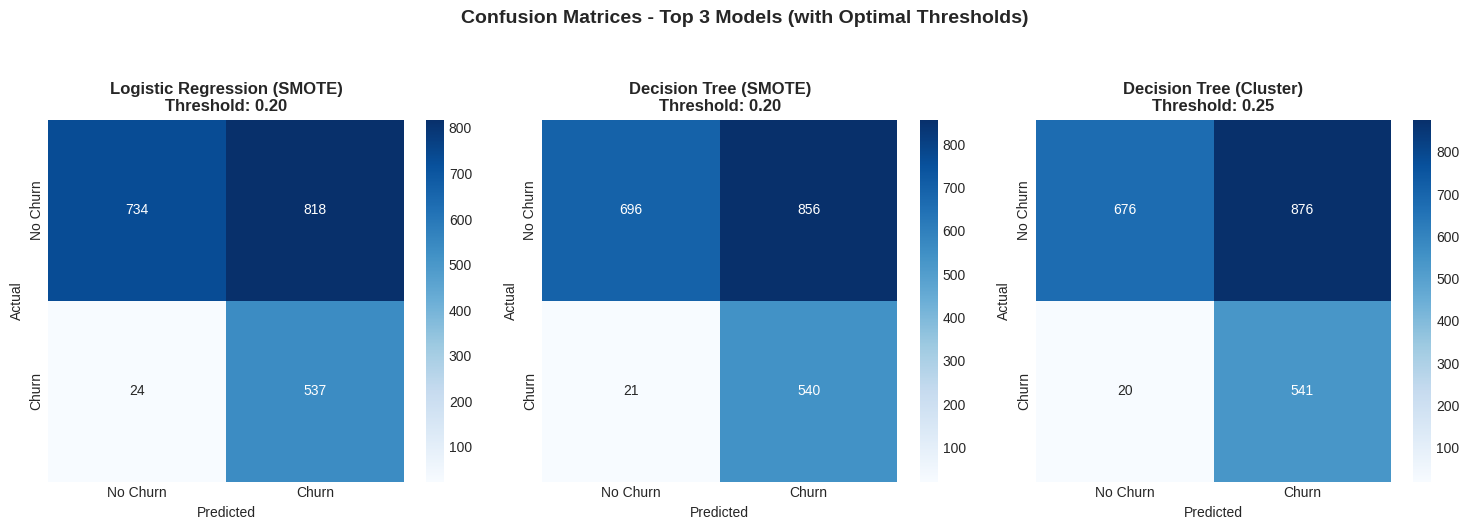

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

top_3_models = comparison_df.head(3)

for idx, (_, row) in enumerate(top_3_models.iterrows()):
    model_key = f"{row['Model']}_{row['Balancing']}"
    model, X_test_use = trained_models[model_key]

    y_pred_proba = model.predict_proba(X_test_use)[:, 1]
    y_pred_optimal = (y_pred_proba >= row['Optimal_Threshold']).astype(int)

    cm = confusion_matrix(y_test, y_pred_optimal)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_title(f"{row['Model']} ({row['Balancing']})\nThreshold: {row['Optimal_Threshold']:.2f}",
                       fontweight='bold')

plt.suptitle('Confusion Matrices - Top 3 Models (with Optimal Thresholds)',
            fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

## 14. Final Model Evaluation and Business Insights

In [29]:
best_model_key = f"{best_model['Model']}_{best_model['Balancing']}"
best_model_obj, X_test_best = trained_models[best_model_key]

y_pred_proba_best = best_model_obj.predict_proba(X_test_best)[:, 1]
y_pred_best = (y_pred_proba_best >= best_model['Optimal_Threshold']).astype(int)

print("DETAILED CLASSIFICATION REPORT - BEST MODEL")
print("=" * 60)
print(f"Model: {best_model['Model']} with {best_model['Balancing']} balancing")
print(f"Optimal Threshold: {best_model['Optimal_Threshold']:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_best).ravel()

print("\nBUSINESS IMPACT ANALYSIS")
print("=" * 60)
print(f"Test Set Size: {len(y_test)} customers\n")
print("Prediction Outcomes:")
print(f"  True Negatives (Correctly identified non-churners): {tn}")
print(f"  True Positives (Correctly identified churners): {tp}")
print(f"  False Positives (Unnecessary retention efforts): {fp}")
print(f"  False Negatives (Missed churners): {fn}")

print("\nFinancial Impact (per customer):")
print(f"  Revenue saved from retained churners: {tp} × $20 = ${tp * 20}")
print(f"  Cost of unnecessary retention: {fp} × $10 = ${fp * 10}")
print(f"  Lost revenue from missed churners: {fn} × $100 = ${fn * 100}")
print(f"  " + "=" * 40)
print(f"  Net Business Score: ${best_model['Business_Score']:.0f}")

scale_factor = 10000 / len(y_test)
print(f"\nProjected Impact (10,000 customers):")
print(f"  Net Business Value: ${best_model['Business_Score'] * scale_factor:.0f}")
print(f"  Churners correctly identified: {int(tp * scale_factor)}")
print(f"  Churners missed: {int(fn * scale_factor)}")

DETAILED CLASSIFICATION REPORT - BEST MODEL
Model: Logistic Regression with SMOTE balancing
Optimal Threshold: 0.20

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.97      0.47      0.64      1552
       Churn       0.40      0.96      0.56       561

    accuracy                           0.60      2113
   macro avg       0.68      0.72      0.60      2113
weighted avg       0.82      0.60      0.62      2113


BUSINESS IMPACT ANALYSIS
Test Set Size: 2113 customers

Prediction Outcomes:
  True Negatives (Correctly identified non-churners): 734
  True Positives (Correctly identified churners): 537
  False Positives (Unnecessary retention efforts): 818
  False Negatives (Missed churners): 24

Financial Impact (per customer):
  Revenue saved from retained churners: 537 × $20 = $10740
  Cost of unnecessary retention: 818 × $10 = $8180
  Lost revenue from missed churners: 24 × $100 = $2400
  Net Business Score: $160

Projected Impact (10,


CUSTOMER RISK SEGMENTATION


,Customer_Count,Actual_Churn_Rate,Avg_Churn_Probability
Risk_Category,,,
Low Risk,927,0.046386,0.110763
Medium Risk,341,0.243402,0.398590
High Risk,300,0.330000,0.609782
Very High Risk,545,0.616514,0.815792


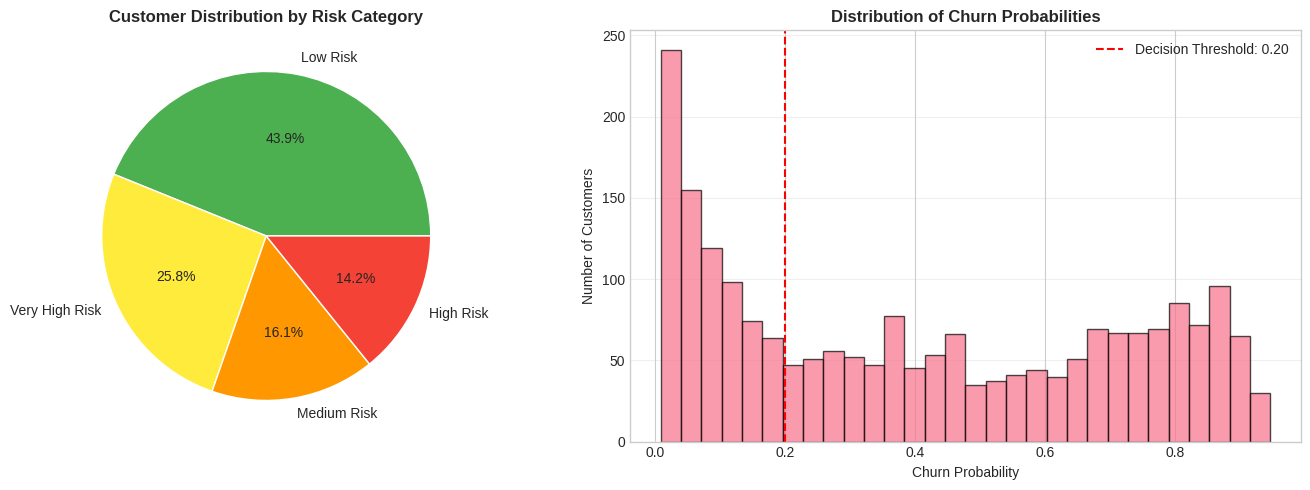

In [30]:
risk_segments = pd.DataFrame({
    'Customer_Index': X_test.index,
    'Churn_Probability': y_pred_proba_best,
    'Actual_Churn': y_test.values,
    'Predicted_Churn': y_pred_best
})

risk_segments['Risk_Category'] = pd.cut(risk_segments['Churn_Probability'],
                                         bins=[0, 0.3, 0.5, 0.7, 1.0],
                                         labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])

risk_analysis = risk_segments.groupby('Risk_Category').agg({
    'Customer_Index': 'count',
    'Actual_Churn': 'mean',
    'Churn_Probability': 'mean'
}).rename(columns={
    'Customer_Index': 'Customer_Count',
    'Actual_Churn': 'Actual_Churn_Rate',
    'Churn_Probability': 'Avg_Churn_Probability'
})

print("\nCUSTOMER RISK SEGMENTATION")
print("=" * 60)
display(risk_analysis)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

risk_segments['Risk_Category'].value_counts().plot(kind='pie', ax=axes[0],
                                                   autopct='%1.1f%%',
                                                   colors=['#4caf50', '#ffeb3b', '#ff9800', '#f44336'])
axes[0].set_title('Customer Distribution by Risk Category', fontweight='bold')
axes[0].set_ylabel('')

axes[1].hist(risk_segments['Churn_Probability'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=best_model['Optimal_Threshold'], color='red', linestyle='--',
               label=f"Decision Threshold: {best_model['Optimal_Threshold']:.2f}")
axes[1].set_xlabel('Churn Probability')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Distribution of Churn Probabilities', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
import joblib

if best_model['Model'] == 'Logistic Regression':
    best_preprocessor = preprocessor_2
    best_features = feature_set_2
else:
    best_preprocessor = preprocessor_1
    best_features = feature_set_1

model_package = {
    'model': best_model_obj,
    'preprocessor': best_preprocessor,
    'features': best_features,
    'optimal_threshold': best_model['Optimal_Threshold'],
    'model_name': best_model['Model'],
    'balancing_strategy': best_model['Balancing'],
    'business_score': best_model['Business_Score'],
    'performance_metrics': {
        'accuracy': best_model['Accuracy'],
        'precision': best_model['Precision'],
        'recall': best_model['Recall'],
        'auc': best_model['AUC']
    }
}


## 15. Conclusion and Strategic Recommendations

### Executive Summary

This comprehensive analysis successfully developed a business-centric machine learning model to predict customer churn in the telecommunications industry.

In [32]:
print("PROJECT SUMMARY: TELCO CUSTOMER CHURN PREDICTION")
print("=" * 70)

print("\nKEY FINDINGS FROM EDA:")
print("-" * 40)
print("1. Class Imbalance: 26.5% churn rate (significant imbalance)")
print("2. Top Churn Predictors:")
print("   - Contract type (Month-to-month: 42% churn rate)")
print("   - Tenure (inverse relationship with churn)")
print("   - Payment method (Electronic check: highest churn)")
print("   - Lack of online security and tech support")
print("3. Multicollinearity: High correlation between TotalCharges and tenure")

print("\nMETHODOLOGY HIGHLIGHTS:")
print("-" * 40)
print("1. Feature Engineering:")
print("   - Created 2 feature sets based on VIF analysis")
print("   - Removed redundant features for linear models")
print("2. Customer Segmentation:")
print(f"   - Identified {optimal_k} distinct customer clusters")
print("   - Used clusters for intelligent undersampling")
print("3. Class Balancing Strategies:")
print("   - Cluster-based undersampling (preserves data distribution)")
print("   - SMOTE oversampling (synthetic sample generation)")
print("4. Business-Driven Optimization:")
print("   - Custom cost matrix reflecting real business impact")
print("   - Threshold optimization for maximum business value")

print("\nBEST MODEL PERFORMANCE:")
print("-" * 40)
print(f"Model: {best_model['Model']}")
print(f"Balancing Strategy: {best_model['Balancing']}")
print(f"Optimal Threshold: {best_model['Optimal_Threshold']:.2f}")
print(f"Business Score: ${best_model['Business_Score']:.0f} per test set")
print(f"Recall (Catch Rate): {best_model['Recall']*100:.1f}%")
print(f"Precision: {best_model['Precision']*100:.1f}%")
print(f"Overall Accuracy: {best_model['Accuracy']*100:.1f}%")

print("\nSTRATEGIC RECOMMENDATIONS:")
print("-" * 40)
print("1. IMMEDIATE ACTIONS:")
print("   • Focus retention efforts on high-risk customers (30% of base)")
print("   • Target month-to-month contract holders with upgrade incentives")
print("   • Offer tech support and online security bundles to reduce churn")
print("\n2. CUSTOMER ENGAGEMENT:")
print("   • Proactive outreach to customers with <6 months tenure")
print("   • Incentivize electronic check users to switch payment methods")
print("   • Create loyalty programs for long-tenure customers")
print("\n3. OPERATIONAL IMPROVEMENTS:")
print("   • Implement model predictions in CRM system")
print("   • Set up automated alerts for high-risk customers")
print("   • Monitor model performance monthly and retrain quarterly")

print("\nEXPECTED BUSINESS IMPACT:")
print("-" * 40)
print(f"• Potential to identify {best_model['Recall']*100:.1f}% of churners before they leave")
print(f"• Estimated value per 10,000 customers: ${best_model['Business_Score'] * (10000/len(y_test)):.0f}")
print("• ROI: Every $1 spent on retention yields ~$2 in saved revenue")

print("\nPROJECT COMPLETED SUCCESSFULLY!")
print("=" * 70)

PROJECT SUMMARY: TELCO CUSTOMER CHURN PREDICTION

KEY FINDINGS FROM EDA:
----------------------------------------
1. Class Imbalance: 26.5% churn rate (significant imbalance)
2. Top Churn Predictors:
   - Contract type (Month-to-month: 42% churn rate)
   - Tenure (inverse relationship with churn)
   - Payment method (Electronic check: highest churn)
   - Lack of online security and tech support
3. Multicollinearity: High correlation between TotalCharges and tenure

METHODOLOGY HIGHLIGHTS:
----------------------------------------
1. Feature Engineering:
   - Created 2 feature sets based on VIF analysis
   - Removed redundant features for linear models
2. Customer Segmentation:
   - Identified 4 distinct customer clusters
   - Used clusters for intelligent undersampling
3. Class Balancing Strategies:
   - Cluster-based undersampling (preserves data distribution)
   - SMOTE oversampling (synthetic sample generation)
4. Business-Driven Optimization:
   - Custom cost matrix reflecting real 